In [65]:
import numpy as np
from tensorflow.keras.utils import img_to_array
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Sequential
from keras.callbacks import LambdaCallback
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio
import tensorflow_docs.vis.embed as embed



# Disregard this
Only used to set up GPU for ML training


In [92]:
img_size=512 #Size of image in pixels
img_data=[] #Array for image
img=cv2.imread('color.png', 1) #reading image
rgb_img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #converting to rgb
rgb_img=cv2.resize(rgb_img, (512,512)) #resizing image
img_data.append(img_to_array(rgb_img)) #converting image to array
img_final=np.reshape(img_data, (len(img_data),512, 512, 3)) #reshaping image to correct type
img_final=img_final.astype('float32')/255 #Normalizing image 
print(img_final.dtype)
print(img_final.shape)

float32
(1, 512, 512, 3)


In [96]:
model=Sequential()
#Encoder
model.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(512,512,3)))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(Dropout(rate=0.4))

model.add(Conv2D(64, (3,3),activation='relu',padding='same'))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(Dropout(rate=0.4))




#Decoder

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))

model.add(Conv2D(3, (3,3), activation='relu', padding='same'))

#compiling model
optimizer = tf.keras.optimizers.Adam(lr=0.01) #Fuck around with the learning rate
model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['accuracy'])

model.summary()






Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_130 (Conv2D)         (None, 512, 512, 64)      1792      
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 256, 256, 64)     0         
 g2D)                                                            
                                                                 
 dropout_37 (Dropout)        (None, 256, 256, 64)      0         
                                                                 
 conv2d_131 (Conv2D)         (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 128, 128, 64)     0         
 g2D)                                                            
                                                                 
 dropout_38 (Dropout)        (None, 128, 128, 64)    

In [100]:

class AutoencoderPredictCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, data, save_dir):
        super(AutoencoderPredictCallback, self).__init__()
        self.model = model
        self.data = data
        self.save_dir = save_dir

    def on_epoch_end(self, epoch, logs=None):
        # Make predictions using the Autoencoder model
        reconstructed = self.model.predict(self.data)

        # Plot the reconstructed images
        fig = plt.figure(figsize=(5,5))
        plt.imshow(reconstructed.reshape(512, 512,3))
        plt.axis('off')

        # Save the plot as a PNG file
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
        plt.savefig(f"{self.save_dir}/reconstructed_epoch_{epoch}.png")
        plt.close(fig)


In [101]:
epochs=10 #Fuck around with the epochs
save_dir = "./reconstructed_images/"
predict_callback = AutoencoderPredictCallback(model, img_final, save_dir)
model_train = model.fit(img_final, img_final, 
                        epochs=epochs, 
                        callbacks=[predict_callback]
                        )

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.0096 - accuracy: 0.9183
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.0096 - accuracy: 0.9185
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.0096 - accuracy: 0.9159
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.0096 - accuracy: 0.9178
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.0094 - accuracy: 0.9197
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.0095 - accuracy: 0.9170
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.0093 - accuracy: 0.9196
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.0094 - accuracy: 0.9181
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.0094 - accuracy: 0.9188
Epoch 10/10
1/1 [==============================] - 1s 1s/step - loss: 0.0093 - accuracy: 0.9198


1/1 [==============================] - 0s 159ms/step


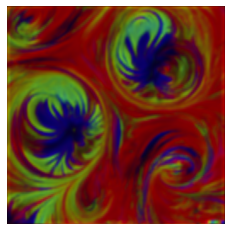

In [99]:
pred=model.predict(img_final)
plt.axis("off")
plt.imshow(pred.reshape(512,512,3))
#plt.savefig("recreatecat.png")

# This kinda works 

In [117]:
from PIL import Image
import glob

# Set the path to the folder containing the images
image_folder = './reconstructed_images/'

# Set the name of the output GIF file
output_file = 'animation.gif'

# Get a list of all the image file names in the folder
image_files = glob.glob(image_folder + '*.png')

# Sort the file names alphabetically to ensure they are in the correct order
image_files.sort()
# Open each image and add it to a list
images = []
for filename in image_files:
    images.append(Image.open(filename))

# Save the images as a GIF
images[0].save(output_file, save_all=True, append_images=images[1:], duration=60, loop=0)
